# Fundamentals of Data Science - Sentiment Analysis on twitter Data

## Import Data set

In [1]:
import pandas as pd
from pprint import pprint
#pd.set_option('display.max_colwidth', -1)
import json
import re

from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

from nltk.tokenize import RegexpTokenizer
import html.parser as HTMLParser# In Python 3.4+ import html 
import nltk

import matplotlib.pyplot as plt
from nltk.corpus import twitter_samples

import nltk.classify.util
from nltk.classify import NaiveBayesClassifier

from textblob import TextBlob as tb

from wordcloud import WordCloud

import itertools
import folium 
import numpy as np

In [2]:
S_DIR = r'C:\Users\ruche\Downloads\geotagged_tweets_20160812-0912.1000.jsons'
tweets_data = []
tweets_file = open(S_DIR, "r")

for line in tweets_file:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        continue
# This creates a python list of strings with json data in the string.  

In [3]:
# Print the keys of the dataset collected from one tweet 
# This gives an overview of what information is in the dataset
print(tweets_data[0].keys())

len(tweets_data)
#inspect the keys that may be necessary for sentiment analysis. Essentially the tweet is the most important part

dict_keys(['created_at', 'id', 'id_str', 'text', 'source', 'truncated', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'entities', 'extended_entities', 'favorited', 'retweeted', 'possibly_sensitive', 'filter_level', 'lang', 'timestamp_ms'])


1000

In [4]:
# A function that extracts the hyperlinks from the tweet's content.
def extract_link(text):
    regex = r'https?://[^\s<>"]+|www\.[^\s<>"]+'
    match = re.search(regex, text)
    if match:
        return match.group()
    return ''

# A function that checks whether a word is included in the tweet's content
def word_in_text(word, text):
    word = word.lower()
    text = text.lower()
    match = re.search(word, text)
    if match:
        return True
    return False

In [5]:
tweets_data = pd.read_parquet("aug_file.parquet")
pprint(tweets_data.keys())

Index(['created_at', 'place.country', 'place.country_code', 'place.name',
       'is_quote_status', 'lang', 'source', 'text', 'user.created_at',
       'user.description', 'user.name', 'user.location', 'place.place_type',
       'user.screen_name', 'in_reply_to_screen_name', 'geo.type',
       'geo.coordinates', 'create_dtm'],
      dtype='object')


In [6]:
columns = ["text", "place.country", "user.location", "place.name"]
tweets_data = pd.read_parquet("aug_file.parquet", columns=columns)
print(tweets_data.keys())

tweets = tweets_data.rename(columns={"text": "text", "place.country": "country", "user.location": "country_code", "place.name" : "place_name"})
tweets

Index(['text', 'place.country', 'user.location', 'place.name'], dtype='object')


,text,country,country_code,place_name
index,,,,
1970-01-01 00:00:00+00:00,@theblaze @realDonaldTrump https://t.co/TY9DlZ...,United States,Miami,Frontenac
1970-01-01 00:00:00.000000001+00:00,@BarackObama \n@FBI\n@LORETTALYNCH \nALL IN CO...,United States,"Ogletown, DE",Baton Rouge
1970-01-01 00:00:00.000000002+00:00,@theblaze @realDonaldTrump https://t.co/n050DB...,United States,Miami,Frontenac
1970-01-01 00:00:00.000000003+00:00,@HillaryClinton he will do in one year all the...,Australia,Australia,Melbourne
1970-01-01 00:00:00.000000004+00:00,#CNN #newday clear #Trump deliberately throwin...,United States,None,Baltimore
1970-01-01 00:00:00.000000005+00:00,"@realDonaldTrump, you wouldn't recognize a lie...",United States,"Palm Springs, CA",Palm Springs
1970-01-01 00:00:00.000000006+00:00,#Trump2016 #TrumpPence16 #MakeAmericaGreatAgai...,United Kingdom,Stuck in the middle with you,Hammersmith
1970-01-01 00:00:00.000000007+00:00,"""Kid, you know, suing someone? Thats the most ...",United States,"Secaucus, NJ",Secaucus
1970-01-01 00:00:00.000000008+00:00,@HillaryClinton you ARE the co-founder of ISIS...,United States,"Irving, TX",Irving


In [7]:
#tweets = pd.DataFrame()

#tweets['text'] =    list(map(lambda tweet: tweet['text'], tweets_data))
#tweets['lang'] =    list(map(lambda tweet: tweet['lang'], tweets_data))
#tweets['country'] = list(map(lambda tweet: tweet['place']['country'] if tweet['place'] != None else None, tweets_data))
#tweets['state_full'] = list(map(lambda tweet: tweet['place']['full_name'] if tweet['place'] != None else None, tweets_data))
#tweets['state'] = list(map(lambda tweet: tweet['place']['name'] if tweet['place'] != None else None, tweets_data))
#tweets['link'] = tweets['text'].apply(lambda tweet: extract_link(tweet))

#tweets

## Pre-processing imported tweets

In [8]:
def clean_tweet(tweets):
    list_clean_text = []

    for i in tweets:
        # this removes the hyperlink
        result = re.sub(r"http\S+|\B@\S+.|\d+.|\&amp", "", i)
        # this removes the people the text was directed to e.g. @HillaryClinton or @CN
        
        list_clean_text.append(result)
    return list_clean_text

In [48]:
#Lexicon Normalization
#performing stemming and Lemmatization

# Create a set of stopwords
stop = set(stopwords.words('english'))
stop.update(set(["n", "u", "im"]))

# Create a set of punctuation words 
exclude = set(string.punctuation) 

# This is the function makeing the lemmatization
lemma = WordNetLemmatizer()

# In this function we perform the entire cleaning
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

list_clean_text = clean_tweet(tweets["text"])
tweets["clean_text"] = list_clean_text
# This is the clean corpus.
doc_clean = [clean(doc) for doc in list_clean_text] 

In [58]:
# Tokenize text
# Tokenize each clean text
tokenized_tweets = []
tokenizer = RegexpTokenizer(r'\w+')
for i in doc_clean:
    if i == "u":
        print("yes")
    tokens = tokenizer.tokenize(i)
    tokenized_tweets.append(tokens)

tweets["tokens"] = tokenized_tweets

# flatten the list of lists to combine all words in one list
flattened_list_of_tokens = [y for x in tokenized_tweets for y in x]
print(flattened_list_of_tokens[:10])

yes
['collusion', 'together', 'nojustice', 'trumppence', 'one', 'year', 'thing', 'done', 'eight', 'cnn']


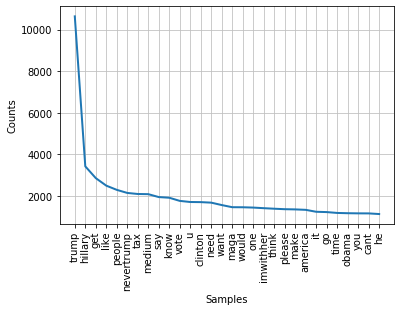

In [50]:
# this function extracts features from text
def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    word_features = wordlist.keys()
    return (wordlist, word_features)

# view most common features
word_features = get_word_features(flattened_list_of_tokens)

word_features[0].most_common(10)

# Frequency Distribution Plot
word_features[0].plot(30,cumulative=False)
plt.show()

## Perform sentiment analysis with ntlk tweets dataset

In [12]:
# extract the positive tweets
pos_tweets = twitter_samples.strings('positive_tweets.json')
len(pos_tweets) # Output: 5000

# extract the negative tweets
neg_tweets = twitter_samples.strings('negative_tweets.json')
len(neg_tweets) # Output: 5000

# print first 5 tweets
#for tweet in pos_tweets[:5]:
#    print(tweet)

5000

In [13]:
# Functions necessary to pre-process the nltk tweets data and return the data in the necessary structure
# A function that extracts which words exist in a text based on a list of words to which we compare.
def word_feats(words):
    return dict([(word, True) for word in words])

# this function takes the cleaned tweets dataset and returns it in the right structure for the naive bayes classifier
def structure_data(doc_clean, sentiment):
    document = []
    for i in doc_clean:
        document.append(i.split())
    features = []
    for i in document:
        features.append((word_feats(i), sentiment))
    return features

In [14]:
negative_campaign_words = ["neverhillary", "nevertrump", "crookedhillary", "crookedtrump", "donthecon", "fraud"
                           "racist", "bigot", "deplorable", "fuckyoudonald", "dumptrump", "hillaryemails", "trumpisunfit"]
positive_campaign_words = ["trump2016", "hillary2016", "imwithher", "imwithhim", "strongertogether"]

In [15]:
# Get the positive features 
cleaned_positive_tweets = clean_tweet(pos_tweets)
pos_doc = [clean(doc) for doc in cleaned_positive_tweets] 
pos_doc_clean =  positive_campaign_words + pos_doc 

pos_feats = structure_data(pos_doc_clean, "pos")

# Get the negative features
cleaned_negative_tweets = clean_tweet(neg_tweets)
neg_doc = [clean(doc) for doc in cleaned_negative_tweets] 
neg_doc_clean =  negative_campaign_words + neg_doc 

neg_feats = structure_data(neg_doc_clean, "neg")

# seperate the data set 75:25 for training:test
neg_cut_off = int(len(neg_feats)*0.80)
pos_cut_off = int(len(pos_feats)*0.80)

In [16]:
# Construct the training dataset containing 50% positive reviews and 50% negative reviews
trainfeats = neg_feats[:neg_cut_off] + pos_feats[:pos_cut_off] 

# Construct the negative dataset containing 50% positive reviews and 50% negative reviews
testfeats = neg_feats[neg_cut_off:] + pos_feats[pos_cut_off:]

print ('train on %d instances, test on %d instances' % (len(trainfeats), len(testfeats)))

# Train a NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(trainfeats)

# Test the trained classifier and display the most informative features.
print ('accuracy:', nltk.classify.util.accuracy(classifier, testfeats))

# See most informative features of the model 
print (classifier.show_most_informative_features(32))

train on 8013 instances, test on 2004 instances
accuracy: 0.7744510978043913
Most Informative Features
                       d = True              pos : neg    =     47.8 : 1.0
                       p = True              pos : neg    =     29.3 : 1.0
                follower = True              pos : neg    =     26.6 : 1.0
                      ff = True              pos : neg    =     26.4 : 1.0
                    sick = True              neg : pos    =     21.0 : 1.0
                     sad = True              neg : pos    =     21.0 : 1.0
               community = True              pos : neg    =     17.7 : 1.0
                    glad = True              pos : neg    =     16.6 : 1.0
                 arrived = True              pos : neg    =     15.9 : 1.0
                     ugh = True              neg : pos    =     15.0 : 1.0
                    miss = True              neg : pos    =     14.5 : 1.0
                 missing = True              neg : pos    =     14.3 : 1

## Testing the model on the tweets dataset

In [17]:
# A list of the classifications
classification = []

# classify each token as positive or negative
for i in tweets["tokens"]:
    classification.append(classifier.classify(word_feats(i)))
    
# make a column of the sentiment/classification of the tweet according to the model
tweets["classification"] = classification
tweets

,text,country,country_code,place_name,clean_text,tokens,classification
index,,,,,,,
1970-01-01 00:00:00+00:00,@theblaze @realDonaldTrump https://t.co/TY9DlZ...,United States,Miami,Frontenac,,[],neg
1970-01-01 00:00:00.000000001+00:00,@BarackObama \n@FBI\n@LORETTALYNCH \nALL IN CO...,United States,"Ogletown, DE",Baton Rouge,\n\n\nALL IN COLLUSION TOGETHER \n\n#NOJUSTICE...,"[collusion, together, nojustice, trumppence]",neg
1970-01-01 00:00:00.000000002+00:00,@theblaze @realDonaldTrump https://t.co/n050DB...,United States,Miami,Frontenac,,[],neg
1970-01-01 00:00:00.000000003+00:00,@HillaryClinton he will do in one year all the...,Australia,Australia,Melbourne,he will do in one year all the things you shou...,"[one, year, thing, done, eight]",pos
1970-01-01 00:00:00.000000004+00:00,#CNN #newday clear #Trump deliberately throwin...,United States,None,Baltimore,#CNN #newday clear #Trump deliberately throwin...,"[cnn, newday, clear, trump, deliberately, thro...",neg
1970-01-01 00:00:00.000000005+00:00,"@realDonaldTrump, you wouldn't recognize a lie...",United States,"Palm Springs, CA",Palm Springs,you wouldn't recognize a lie if it came from y...,"[recognize, lie, came, mouth, continually, nev...",neg
1970-01-01 00:00:00.000000006+00:00,#Trump2016 #TrumpPence16 #MakeAmericaGreatAgai...,United Kingdom,Stuck in the middle with you,Hammersmith,#Trump#TrumpPence#MakeAmericaGreatAgain,[trumptrumppencemakeamericagreatagain],neg
1970-01-01 00:00:00.000000007+00:00,"""Kid, you know, suing someone? Thats the most ...",United States,"Secaucus, NJ",Secaucus,"""Kid, you know, suing someone? Thats the most ...","[kid, know, suing, someone, thats, beautiful, ...",pos
1970-01-01 00:00:00.000000008+00:00,@HillaryClinton you ARE the co-founder of ISIS...,United States,"Irving, TX",Irving,"you ARE the co-founder of ISIS, you crooked, e...","[cofounder, isi, crooked, evil, lying, witch, ...",pos


## Perform sentiment analysis with textblob

In [18]:
tweets['sentiment'] = tweets['tokens'].apply(lambda x: tb(" ".join(x)).sentiment[0] )
#tweets[['text','calc_sentiment']]

tweets

,text,country,country_code,place_name,clean_text,tokens,classification,sentiment
index,,,,,,,,
1970-01-01 00:00:00+00:00,@theblaze @realDonaldTrump https://t.co/TY9DlZ...,United States,Miami,Frontenac,,[],neg,0.000000
1970-01-01 00:00:00.000000001+00:00,@BarackObama \n@FBI\n@LORETTALYNCH \nALL IN CO...,United States,"Ogletown, DE",Baton Rouge,\n\n\nALL IN COLLUSION TOGETHER \n\n#NOJUSTICE...,"[collusion, together, nojustice, trumppence]",neg,0.000000
1970-01-01 00:00:00.000000002+00:00,@theblaze @realDonaldTrump https://t.co/n050DB...,United States,Miami,Frontenac,,[],neg,0.000000
1970-01-01 00:00:00.000000003+00:00,@HillaryClinton he will do in one year all the...,Australia,Australia,Melbourne,he will do in one year all the things you shou...,"[one, year, thing, done, eight]",pos,0.000000
1970-01-01 00:00:00.000000004+00:00,#CNN #newday clear #Trump deliberately throwin...,United States,None,Baltimore,#CNN #newday clear #Trump deliberately throwin...,"[cnn, newday, clear, trump, deliberately, thro...",neg,0.100000
1970-01-01 00:00:00.000000005+00:00,"@realDonaldTrump, you wouldn't recognize a lie...",United States,"Palm Springs, CA",Palm Springs,you wouldn't recognize a lie if it came from y...,"[recognize, lie, came, mouth, continually, nev...",neg,0.000000
1970-01-01 00:00:00.000000006+00:00,#Trump2016 #TrumpPence16 #MakeAmericaGreatAgai...,United Kingdom,Stuck in the middle with you,Hammersmith,#Trump#TrumpPence#MakeAmericaGreatAgain,[trumptrumppencemakeamericagreatagain],neg,0.000000
1970-01-01 00:00:00.000000007+00:00,"""Kid, you know, suing someone? Thats the most ...",United States,"Secaucus, NJ",Secaucus,"""Kid, you know, suing someone? Thats the most ...","[kid, know, suing, someone, thats, beautiful, ...",pos,0.283333
1970-01-01 00:00:00.000000008+00:00,@HillaryClinton you ARE the co-founder of ISIS...,United States,"Irving, TX",Irving,"you ARE the co-founder of ISIS, you crooked, e...","[cofounder, isi, crooked, evil, lying, witch, ...",pos,-0.287879


In [19]:
# compare the model from nltk with textblob
index = 0
counter_different_classif = 0
counter_neutral = 0
counter_pos = 0
comparison = []

for classification in tweets["classification"]:
   # print(tweets["sentiment"][index])
    if classification == "neg" and tweets["sentiment"][index] < 0:
        comparison.append("same negative")
    elif classification == "neg" and tweets["sentiment"][index] > 0:
        comparison.append("different neg : pos")
        counter_pos = counter_pos + 1
        counter_different_classif = counter_different_classif + 1
    elif classification == "pos" and tweets["sentiment"][index] > 0:
        comparison.append("same positive")
        counter_pos = counter_pos + 1
    elif classification == "pos" and tweets["sentiment"][index] < 0:
        comparison.append("different pos : neg")
        counter_different_classif = counter_different_classif + 1
    else:
        comparison.append("different neutral")
        counter_neutral = counter_neutral + 1
    index = index + 1
# this column contains the comparisons, same negative means that both models classified as negative, idem for same positive
# different neutral means that textblob classified as neutral 
# different neg : pos means that naive bayes negative and textblob was positive 
# different pos : neg means that naive bayes positive and textblob was negative 
tweets["comparison"] = comparison

# summary of the comparison
print(f"Out of {len(tweets)} tweets, the models had a different classification {counter_different_classif} times")
print(f"Out of {len(tweets)} tweets, textblob found {counter_neutral} neutral tweets, {counter_pos} positive tweets and {len(tweets) - (counter_neutral + counter_pos)} ")
tweets.groupby(["classification"]).count()

Out of 57710 tweets, the models had a different classification 10992 times
Out of 57710 tweets, textblob found 29543 neutral tweets, 16237 positive tweets and 11930 


,text,country,country_code,place_name,clean_text,tokens,sentiment,comparison
classification,,,,,,,,
neg,31356,31355,23950,31355,31356,31356,31356,31356
pos,26354,26354,20091,26354,26354,26354,26354,26354


In [20]:
pos_words = []
neg_words = []
index = 0
for i in tweets["classification"]:
    if i == "pos":
        pos_words.append(tweets["tokens"][index])
    else:
        neg_words.append(tweets["tokens"][index])
    index = index + 1

def flatten(a_list):
    flattened_list = [y for x in a_list for y in x]
    return flattened_list

all_pos_words = flatten(pos_words)
all_neg_words = flatten(neg_words)

In [21]:
def word_cloud(tweets):
    #We generate the wordcloud using the series created and the mask 
    word_cloud = WordCloud(width=2000, height=1000, max_font_size=500, max_words=100).generate(tweets)

    # plot the wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(word_cloud, interpolation="hermite")
    plt.axis("off")    
    plt.show() 

## Positive

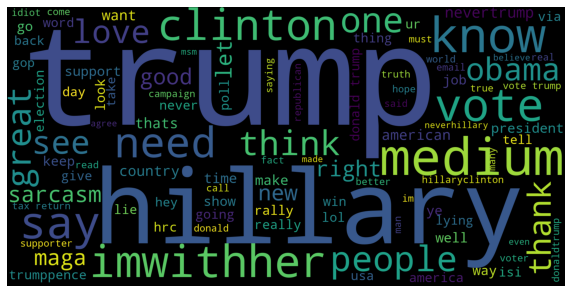

In [22]:
word_cloud(" ".join(all_pos_words))

## Negative

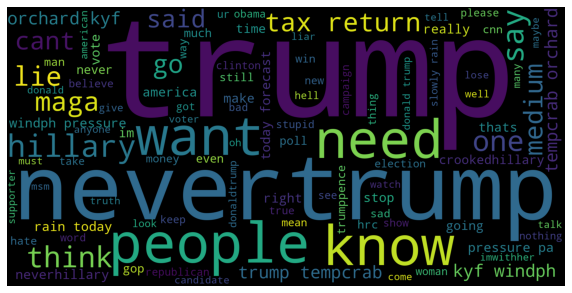

In [23]:
word_cloud(" ".join(all_neg_words))

## Sentiment Analysis Per State

In [24]:
# list of state names and their code (Copied from Hessel)
STATES = ['Alabama', 'AL', 'Alaska', 'AK', 'Arizona', 'AZ', 'Arkansas', 'AR', 'California', 'CA', 'Colorado', 'CO', 'Connecticut', 'CT', \
'Delaware', 'DE', 'Florida', 'FL', 'Georgia', 'GA', 'Hawaii', 'HI', 'Idaho', 'ID', 'Illinois', 'IL', 'Indiana', 'IN', 'Iowa', 'IA', \
'Kansas', 'KS', 'Kentucky', 'KY', 'Louisiana', 'LA', 'Maine', 'ME', 'Maryland', 'MD', 'Massachusetts', 'MA', 'Michigan', 'MI', \
'Minnesota', 'MN', 'Mississippi', 'MS', 'Missouri', 'MO', 'Montana', 'MT', 'Nebraska', 'NE', 'Nevada', 'NV', 'New Hampshire', 'NH', \
'New Jersey', 'NJ', 'New Mexico', 'NM', 'New York', 'NY', 'North Carolina', 'NC', 'North Dakota', 'ND', 'Ohio', 'OH', 'Oklahoma', 'OK', \
'Oregon', 'OR', 'Pennsylvania', 'PA', 'Rhode Island', 'RI', 'South Carolina', 'SC', 'South Dakota', 'SD', 'Tennessee', 'TN', \
'Texas', 'TX', 'Utah', 'UT', 'Vermont', 'VT', 'Virginia', 'VA', 'Washington', 'WA', 'West Virginia', 'WV', 'Wisconsin', 'WI', 'Wyoming', 'WY']

# Make list a dictionary (Copied from Hessel)
STATE_DICT = dict(itertools.zip_longest(*[iter(STATES)] * 2, fillvalue=""))
INV_STATE_DICT = dict((v,k) for k,v in STATE_DICT.items())

In [25]:
# insert a column in the dataframe for each state code (Copied from Hessel)
is_in_US=[]
geo = tweets[['country_code']]
tweets = tweets.fillna(" ")
for x in tweets['country_code']:
    check = False
    for s in STATES:
        if s in x:
            is_in_US.append(STATE_DICT[s] if s in STATE_DICT else s)
            check = True
            break
    if not check:
        is_in_US.append(np.nan)

tweets['state_code'] = is_in_US

In [26]:
# groupby state
# assign a number to the classification positive or negative (e.g. if the tweet is pos then assign number 1)
classification_num = []
for i in tweets["classification"]:
    if i == "pos":
        classification_num.append(1)
    else:
        classification_num.append(-1)
        
# column with the mean positive (1) or negative (-1) number per state
tweets["classification_num"] = classification_num
states_sentiments = tweets.groupby(["state_code"], as_index=False).mean()
states_sentiments

,state_code,sentiment,classification_num
0,AK,0.012300,-0.253333
1,AL,0.027191,-0.156028
2,AR,0.003030,0.057592
3,AZ,0.028678,-0.023359
4,CA,0.027360,-0.060043
5,CO,0.036440,-0.074699
6,CT,0.029428,-0.036415
7,DE,0.028447,-0.132353
8,FL,0.035134,-0.070270
9,GA,0.031855,-0.039914


In [27]:
# Vizualize the sentiment per state
# This is the same as hessel's states but this time I did it with the naive bayes model 

def make_map(df, column, fill_color):
    url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
    state_geo = f'{url}/us-states.json'
    Trump = folium.Map(location=[48, -102], zoom_start=3)

    folium.Choropleth(
        geo_data=state_geo,
        name='choropleth',
        data=df,
        columns=['state_code', column],
        key_on='feature.id',
        fill_color=fill_color,
        fill_opacity=0.9,
        line_opacity=0.2,
        nan_fill_color='black', #For the states where no data is available, the fill color will be blue (democrat)
        nan_fill_opacity=0.8,
        legend_name='Total Votes (%)'
    ).add_to(Trump)

    folium.LayerControl().add_to(Trump)

    return Trump

states = make_map(states_sentiments, "sentiment", "OrRd")
states

## Combining Sentiment analysis with Topic Modeling
### Analyzing the different sentiment between tweets about hillary and tweets about trump

In [28]:
# this function reads a csv into a df and then labels the dataframe according to the topic
def read_label(data):
    df_topic = pd.read_csv(data)
    label = []
    for i in df_topic["dominant_topic"]:
        if i == "Donald Trump":
            label.append("hillary")
        else:
            label.append("trump")
    df_topic["label"] = label
    return df_topic

# dom_topictwo.csv is a csv containing tweets divided by only 2 topics.. trump and hillary
df_topic = read_label("give_a_file_name.csv")

# unnamed: 0 is an id column this is not necessary so we drop it
df_topic = df_topic.drop(['Unnamed: 0'], axis=1)

In [29]:
# merge the tweets df with the df from topic analysis
# this results in one df with each tweet labeled with their topic
# in this case the topics are either hillary or trump
df = (pd.merge(tweets, df_topic, on = "text", how='left'))
df

,text,country,country_code,place_name,clean_text,tokens,classification,sentiment,comparison,state_code,classification_num,dominant_topic,label
0,@theblaze @realDonaldTrump https://t.co/TY9DlZ...,United States,Miami,Frontenac,,[],neg,0.000000,different neutral,NaN,-1,Hillary Clinton,trump
1,@BarackObama \n@FBI\n@LORETTALYNCH \nALL IN CO...,United States,"Ogletown, DE",Baton Rouge,\n\n\nALL IN COLLUSION TOGETHER \n\n#NOJUSTICE...,"[collusion, together, nojustice, trumppence]",neg,0.000000,different neutral,DE,-1,Hillary Clinton,trump
2,@theblaze @realDonaldTrump https://t.co/n050DB...,United States,Miami,Frontenac,,[],neg,0.000000,different neutral,NaN,-1,Hillary Clinton,trump
3,@HillaryClinton he will do in one year all the...,Australia,Australia,Melbourne,he will do in one year all the things you shou...,"[one, year, thing, done, eight]",pos,0.000000,different neutral,NaN,1,Donald Trump,hillary
4,#CNN #newday clear #Trump deliberately throwin...,United States,,Baltimore,#CNN #newday clear #Trump deliberately throwin...,"[cnn, newday, clear, trump, deliberately, thro...",neg,0.100000,different neg : pos,NaN,-1,Hillary Clinton,trump
5,"@realDonaldTrump, you wouldn't recognize a lie...",United States,"Palm Springs, CA",Palm Springs,you wouldn't recognize a lie if it came from y...,"[recognize, lie, came, mouth, continually, nev...",neg,0.000000,different neutral,CA,-1,Hillary Clinton,trump
6,#Trump2016 #TrumpPence16 #MakeAmericaGreatAgai...,United Kingdom,Stuck in the middle with you,Hammersmith,#Trump#TrumpPence#MakeAmericaGreatAgain,[trumptrumppencemakeamericagreatagain],neg,0.000000,different neutral,NaN,-1,Hillary Clinton,trump
7,"""Kid, you know, suing someone? Thats the most ...",United States,"Secaucus, NJ",Secaucus,"""Kid, you know, suing someone? Thats the most ...","[kid, know, suing, someone, thats, beautiful, ...",pos,0.283333,same positive,NJ,1,Hillary Clinton,trump
8,@HillaryClinton you ARE the co-founder of ISIS...,United States,"Irving, TX",Irving,"you ARE the co-founder of ISIS, you crooked, e...","[cofounder, isi, crooked, evil, lying, witch, ...",pos,-0.287879,different pos : neg,TX,1,Donald Trump,hillary
9,@Geraldanthro @NeilTurner_ @realDonaldTrump wa...,Australia,Queensland OZ,Brisbane,want to do a comparison try maimed Vets pre ; ...,"[want, comparison, try, maimed, vet, pre, post...",neg,0.000000,different neutral,NaN,-1,Hillary Clinton,trump


In [30]:
# group the df by the topics
grouped_df = df.groupby(["label"])

# I know the keys are either 0.0 or 1.0 and I know what they mean so I put each df into a variable
trump = grouped_df.get_group("trump")  
hillary = grouped_df.get_group("hillary")

In [31]:
# calculate the mean sentiment
def calculate_mean_sentiment(df_model, df_textblob):
    naive_bayes = df_model.mean()
    textblob = df_textblob.mean()
    return (naive_bayes, textblob)

trump_sentiments = calculate_mean_sentiment(trump["classification_num"], trump["sentiment"])
hillary_sentiments = calculate_mean_sentiment(hillary["classification_num"], hillary["sentiment"])

# this function prints the sentiment per model per topic
def print_sentiments(mean_sentiment, model, topic):
    if mean_sentiment > 0:
        print(f"According to the {model} the general sentiment for {topic} is positive ({mean_sentiment})")
    elif mean_sentiment < 0:
        print(f"According to the {model} the general sentiment for {topic} is negative ({mean_sentiment})")
    else:
        print(f"According to the {model} the general sentiment for {topic} is neutral")

# call the print function with the right parameters
print_sentiments(trump_sentiments[0], "naive bayes model", "trump")
print_sentiments(trump_sentiments[1], "textblob", "trump")
print()
print_sentiments(hillary_sentiments[0], "naive bayes model", "hillary")
print_sentiments(hillary_sentiments[1], "textblob", "hillary")

According to the naive bayes model the general sentiment for trump is negative (-0.23942723942723942)
According to the textblob the general sentiment for trump is positive (0.028225722742491254)

According to the naive bayes model the general sentiment for hillary is positive (0.022932474248654147)
According to the textblob the general sentiment for hillary is positive (0.024755668512201946)


In [32]:

# tried to normalize based on number of tweets...because trump has many more tweets than hillary
print(f"Number of tweets for trump {len(trump)}")
print(f"Number of tweets for hillary {len(hillary)}\n")

# this function attempts to normalize the sentiment because of differences in number of tweets per topic
def normalize_sentiment(mean_sentiment, df):
    return round(mean_sentiment/len(df)*100, 6)
    
# call the normalize sentiment function
print_sentiments(normalize_sentiment(trump_sentiments[0], trump), "naive bayes model", "trump")
print_sentiments(normalize_sentiment(trump_sentiments[1], trump), "textblob", "trump")

print_sentiments(normalize_sentiment(hillary_sentiments[0], hillary), "naive bayes model", "hillary")
print_sentiments(normalize_sentiment(hillary_sentiments[1], hillary), "textblob", "hillary")

# although for trump the sentiment is much more negative than for hillary

Number of tweets for trump 39039
Number of tweets for hillary 23591

According to the naive bayes model the general sentiment for trump is negative (-0.000613)
According to the textblob the general sentiment for trump is positive (7.2e-05)
According to the naive bayes model the general sentiment for hillary is positive (9.7e-05)
According to the textblob the general sentiment for hillary is positive (0.000105)


## Sentiment analysis with Topic Modeling per state
### Analyzing the different sentiment in each state between tweets about hillary and tweets about trump

In [33]:
trump_sentiment = trump.groupby(["state_code"], as_index=False).mean()
trump_map = make_map(trump_sentiment, "sentiment", "OrRd")
trump_map

In [34]:
hillary_sentiment = hillary.groupby(["state_code"], as_index=False).mean()
hillary_map = make_map(hillary_sentiment, "sentiment", "PuBu")
hillary_map